<font color='orange'>**Please create your own copy before starting modification**</font>

Dependencies: Add Your dependencies here



In [13]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Load the data

In [2]:
df = pd.read_csv('/content/train.csv')

In [3]:
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


Plot the count for each target

0    4342
1    3271
Name: target, dtype: int64


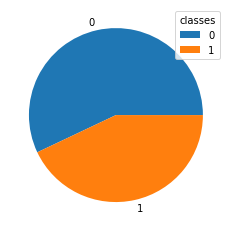

In [4]:
classes = df['target'].value_counts()
print(classes)
plt.pie([classes[0],classes[1]],labels=[0,1])
plt.legend(title = "classes")

Print the unique keywords

In [5]:
df['keyword'].value_counts()[:20]

fatalities     45
armageddon     42
deluge         42
damage         41
sinking        41
harm           41
body%20bags    41
windstorm      40
collided       40
fear           40
siren          40
evacuate       40
outbreak       40
twister        40
collision      39
whirlwind      39
weapon         39
derailment     39
explosion      39
wreckage       39
Name: keyword, dtype: int64

Plot the count of each keyword

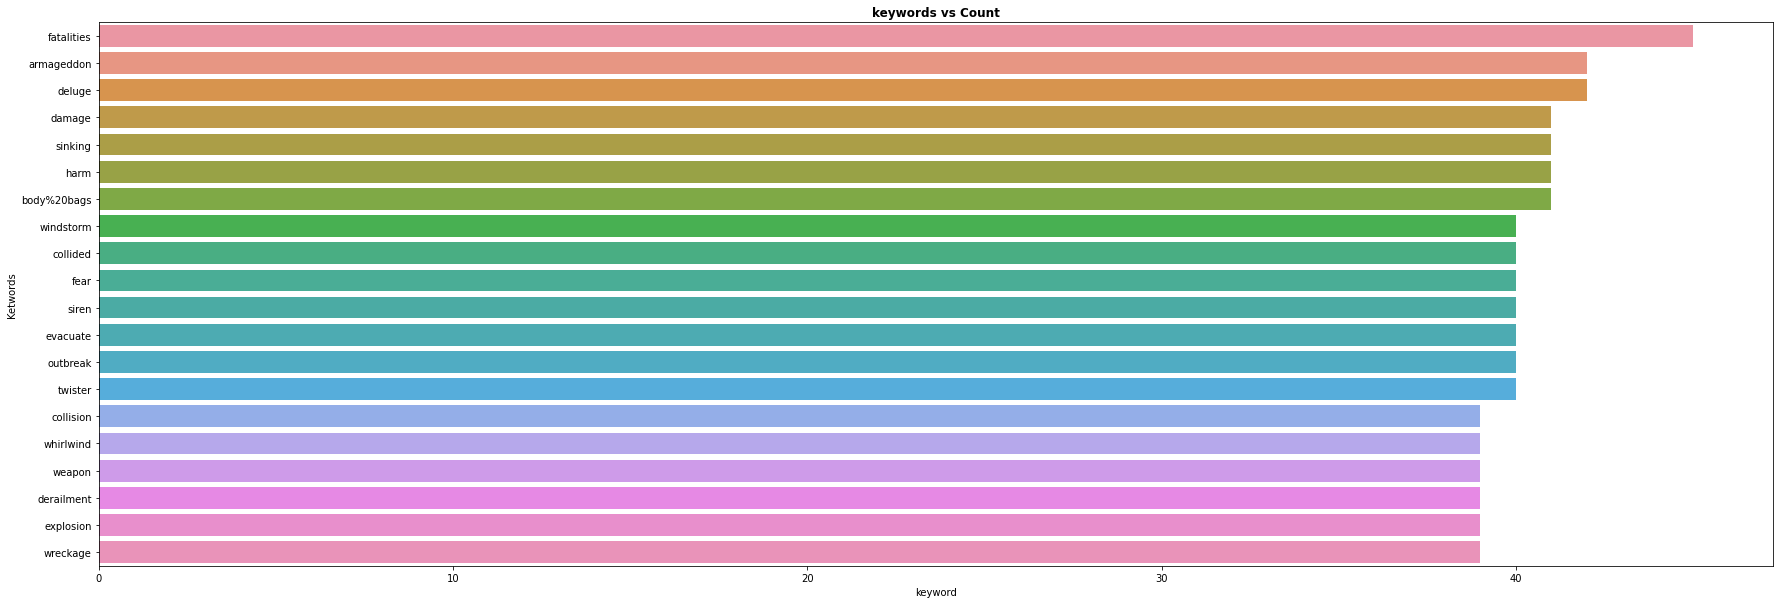

In [6]:
df_fake = df.loc[df['target']==0]
df_real = df.loc[df['target']==1]
plt.figure(figsize=(30,10))
plt.ylabel('Ketwords')
plt.title('keywords vs Count',fontweight='bold')
sns.barplot(y=df['keyword'].value_counts()[:20].index,x=df['keyword'].value_counts()[:20])
plt.show()

Is there any correlation of the length of a tweet with its target. Try to visualize

In [7]:
#Average tweet length
print(df['text'].str.len().mean())
#Average Word length of the tweet for seperate real and fake set
wlen_fake = df_fake['text'].str.split().apply(lambda x: len(x))
wlen_real = df_real['text'].str.split().apply(lambda x: len(x))
print("mean of fake class = ",{wlen_fake.mean()})
print("mean of real class = ",{wlen_real.mean()})

101.03743596479706
mean of fake class =  {14.704744357438969}
mean of real class =  {15.167532864567411}


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



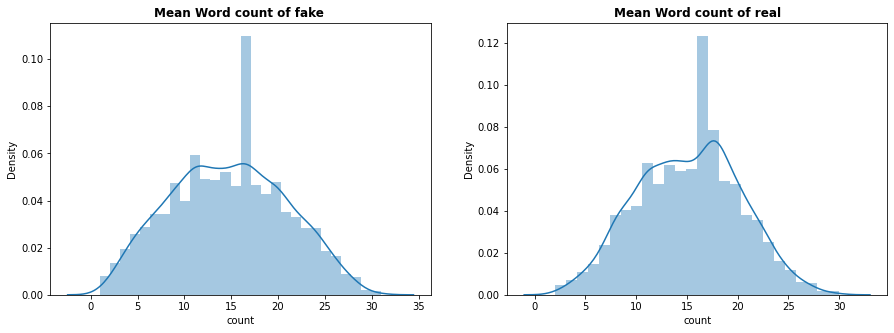

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Mean Word count of fake ",fontweight='bold')
sns.distplot(wlen_fake.map(lambda x: np.mean(x)))
plt.xlabel('count')
plt.subplot(122)
plt.title("Mean Word count of real",fontweight='bold')
sns.distplot(wlen_real.map(lambda x: np.mean(x)))
plt.xlabel('count')
plt.show()

Print the number of null values in each column

In [9]:
null_counts = df.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

location    2533
keyword       61
dtype: int64

Remove the null values

In [10]:
# from the above result its clear that their is no nul value in text and target row so we don't need to remove this because if we remove this data we left with small traning 
# data set without any good so i think we not need to detele null data


Remove:


1.   Double Spaces
2.   Hypens and arrows
3.   Emojis
4.   URL
5.   Any other non english or special symbol

Replace wrong spellings with correct spellings



In [11]:
df["txt_lower"] = df["text"].str.lower()

In [14]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

df["txt_urls"] = df["txt_lower"].apply(lambda text: remove_urls(text))

In [15]:
# remove punctuation
remove_punct = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', remove_punct))

df["txt_punct_urls"] = df["txt_urls"].apply(lambda text: remove_punctuation(text))

In [16]:
#remove double space
def remove_double_space(text):
    return re.sub("\s\s"," ",text)
df["txt_punct_urls_doubSpace"] = df["txt_punct_urls"].apply(lambda text: remove_double_space(text))
df["txt_punct_urls_doubSpace"]

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3       13000 people receive wildfires evacuation orde...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610                m194 0104 utc5km s of volcano hawaii 
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: txt_punct_urls_doubSpace, Length: 7613, dtype: object

In [17]:
# remove emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" 
                           u"\U0001F300-\U0001F5FF" 
                           u"\U0001F680-\U0001F6FF"  
                           u"\U0001F1E0-\U0001F1FF"
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

df["txt_punct_urls_doubSpace_emojis"] = df["txt_punct_urls_doubSpace"].apply(lambda text: remove_emoji(text))

In [18]:
# remove nonenglish
def remove_non_english(text):
    return re.sub("[^a-zA-Z]"," ",text)
df["txt_punct_urls_doubSpace_emojis_nonEng"] = df["txt_punct_urls_doubSpace_emojis"].apply(lambda text: remove_non_english(text))

In [19]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7MB 7.7MB/s 


In [20]:
from spellchecker import SpellChecker
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
df["txt_punct_urls_doubSpace_emojis_nonEng_wronspell"] = df["txt_punct_urls_doubSpace_emojis_nonEng"].apply(lambda text: correct_spellings(text))

In [21]:
df=df.iloc[:,0:13]
df

,id,keyword,location,text,target,txt_lower,txt_urls,txt_punct_urls,txt_punct_urls_doubSpace,txt_punct_urls_doubSpace_emojis,txt_punct_urls_doubSpace_emojis_nonEng,txt_punct_urls_doubSpace_emojis_nonEng_wronspell
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,our deeds are the reason of this #earthquake m...,our deeds are the reason of this #earthquake m...,our deeds are the reason of this earthquake ma...,our deeds are the reason of this earthquake ma...,our deeds are the reason of this earthquake ma...,our deeds are the reason of this earthquake ma...,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask. canada,forest fire near la ronge sask. canada,forest fire near la ronge sask canada,forest fire near la ronge sask canada,forest fire near la ronge sask canada,forest fire near la ronge sask canada,forest fire near la range ask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,all residents asked to 'shelter in place' are ...,all residents asked to 'shelter in place' are ...,all residents asked to shelter in place are be...,all residents asked to shelter in place are be...,all residents asked to shelter in place are be...,all residents asked to shelter in place are be...,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation or...","13,000 people receive #wildfires evacuation or...",13000 people receive wildfires evacuation orde...,13000 people receive wildfires evacuation orde...,13000 people receive wildfires evacuation orde...,people receive wildfires evacuation orde...,people receive wildfires evacuation orders in ...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,just got sent this photo from ruby #alaska as ...,just got sent this photo from ruby #alaska as ...,just got sent this photo from ruby alaska as s...,just got sent this photo from ruby alaska as s...,just got sent this photo from ruby alaska as s...,just got sent this photo from ruby alaska as s...,just got sent this photo from ruby alaska as s...
...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...,two giant cranes holding a bridge collapse int...
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,@aria_ahrary @thetawniest the out of control w...,@aria_ahrary @thetawniest the out of control w...,ariaahrary thetawniest the out of control wild...,ariaahrary thetawniest the out of control wild...,ariaahrary thetawniest the out of control wild...,ariaahrary thetawniest the out of control wild...,ariaahrary thetawniest the out of control wild...
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,m1.94 [01:04 utc]?5km s of volcano hawaii.,m194 0104 utc5km s of volcano hawaii,m194 0104 utc5km s of volcano hawaii,m194 0104 utc5km s of volcano hawaii,m utc km s of volcano hawaii,i ut am i of volcano hawaii
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,police investigating after an e-bike collided ...,police investigating after an e-bike collided ...,police investigating after an ebike collided w...,police investigating after an ebike collided w...,police investigating after an ebike collided w...,police investigating after an ebike collided w...,police investigating after an bike collided wi...


Plot a word cloud of real target and fake target

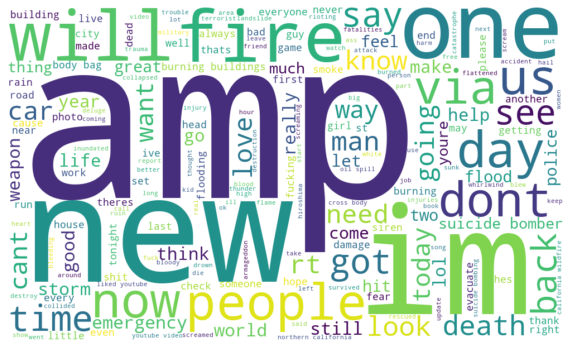

In [22]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
text = " ".join(review for review in df.txt_punct_urls_doubSpace_emojis_nonEng)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white",width=1000, height=600).generate(text)
plt.rcParams["figure.figsize"] = (10, 10)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
def txt_target_cloud(label):
  text = ''
  for word in df[df['target'] == label]['txt_punct_urls_doubSpace_emojis_nonEng']:
    word= word.lower()
    text += word + ' '
  wordcloud = WordCloud(stopwords=stopwords, background_color="white",width=1000, height=600).generate(text)
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

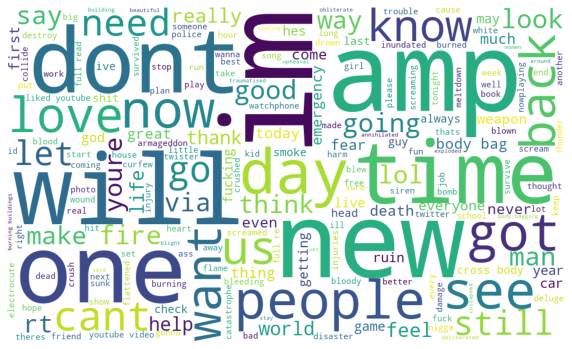

In [25]:
txt_target_cloud(0)

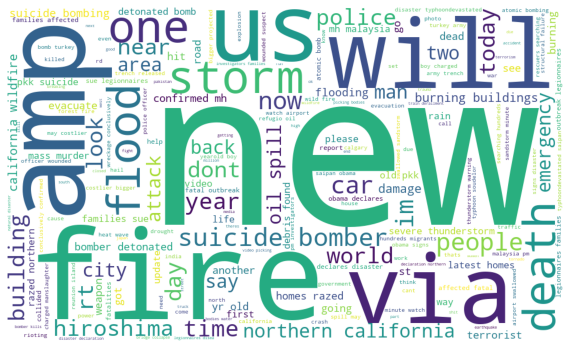

In [26]:
txt_target_cloud(1)

Keep only text and target column in the dataset

In [28]:
df['text']=df['txt_punct_urls_doubSpace_emojis_nonEng_wronspell']
df['text']

0       our deeds are the reason of this earthquake ma...
1                    forest fire near la range ask canada
2       all residents asked to shelter in place are be...
3       people receive wildfires evacuation orders in ...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609    ariaahrary thetawniest the out of control wild...
7610                          i ut am i of volcano hawaii
7611    police investigating after an bike collided wi...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [29]:
df = df[['text','target']]
df

,text,target
0,our deeds are the reason of this earthquake ma...,1
1,forest fire near la range ask canada,1
2,all residents asked to shelter in place are be...,1
3,people receive wildfires evacuation orders in ...,1
4,just got sent this photo from ruby alaska as s...,1
...,...,...
7608,two giant cranes holding a bridge collapse int...,1
7609,ariaahrary thetawniest the out of control wild...,1
7610,i ut am i of volcano hawaii,1
7611,police investigating after an bike collided wi...,1


Split data into train and validation

In [30]:
X = df['text']
y = df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train, y_train) 

4996    courageous and honest analysis of need to use ...
3263    zachzaidman theodore old i a shame if that gol...
4907    tell barackobama to rescind medals of honor gi...
2855    worried about how the ca drought might affect ...
4716    youngheroesid lava blast amp power red panther...
                              ...                        
5226    thanator there arent many obliteration servers...
5390    just had a panic attack be i dont have enough ...
860     moron hem i automatic blood pressure monitor s...
7603    officials say a quarantine is in place at an a...
7270    i moved to england five years ago today what a...
Name: text, Length: 6090, dtype: object 4996    1
3263    0
4907    1
2855    1
4716    0
       ..
5226    0
5390    0
860     0
7603    1
7270    1
Name: target, Length: 6090, dtype: int64


Print the count of unique words

In [48]:

target_0 = []
target_1 = []
for i in range(0,len(df)):
  if(df['target'].ravel()[i]==0):
    target_0.append(df['text'].ravel()[i])
  else:
    target_1.append(df['text'].ravel()[i])

In [49]:
class1_words = []
class0_words = []
for i in target_0:
  for j in i.split():
    class0_words.append(j)
for i in targ1:
  for j in i.split():
    class1_words.append(j)
print(class1_words, class0_words)

['our', 'deeds', 'are', 'the', 'reason', 'of', 'this', 'earthquake', 'may', 'allah', 'forgive', 'us', 'all', 'forest', 'fire', 'near', 'la', 'range', 'ask', 'canada', 'all', 'residents', 'asked', 'to', 'shelter', 'in', 'place', 'are', 'being', 'notified', 'by', 'officers', 'no', 'other', 'evacuation', 'or', 'shelter', 'in', 'place', 'orders', 'are', 'expected', 'people', 'receive', 'wildfires', 'evacuation', 'orders', 'in', 'california', 'just', 'got', 'sent', 'this', 'photo', 'from', 'ruby', 'alaska', 'as', 'smoke', 'from', 'wildfires', 'pours', 'into', 'a', 'school', 'rockyfire', 'update', 'california', 'why', 'closed', 'in', 'both', 'directions', 'due', 'to', 'lake', 'county', 'fire', 'afire', 'wildfires', 'flood', 'disaster', 'heavy', 'rain', 'causes', 'flash', 'flooding', 'of', 'streets', 'in', 'manitou', 'colorado', 'springs', 'areas', 'im', 'on', 'top', 'of', 'the', 'hill', 'and', 'i', 'can', 'see', 'a', 'fire', 'in', 'the', 'woods', 'theres', 'an', 'emergency', 'evacuation', 'h

Compute the Term-Document Matrix (TDM) for all classes.

Use CountVectorizer of sklearn and print the dataframe with number of columns = number of unique words and the row showing the count of that word in a sentence.

In [50]:
from sklearn.feature_extraction.text import CountVectorizer

In [52]:
vectorizer0 = CountVectorizer()
c0_vectorizer = vectorizer0.fit_transform(class0_words)
vectorizer1 = CountVectorizer()
c1_vectorizer = vectorizer1.fit_transform(class1_words)

In [53]:
print(vectorizer0.get_feature_names())
print(vectorizer1.get_feature_names())
print(c0_vectorizer.toarray())
print(c1_vectorizer.toarray())

['aaceorg', 'aannnnd', 'aaronthefm', 'ab', 'aba', 'abandon', 'abandoned', 'abandonedpics', 'abandoning', 'abbott', 'abbruchsimulator', 'abc', 'abe', 'aberdeen', 'aberdeenfanpage', 'abhor', 'ability', 'abject', 'ablaze', 'able', 'abomination', 'abortion', 'abortions', 'about', 'above', 'abrancaballero', 'absolute', 'absolutely', 'absolutsumya', 'abstract', 'absurdly', 'abubaraa', 'abuse', 'abused', 'abuseddesolateamplost', 'abysmaljoiner', 'abyss', 'ac', 'acaciapenn', 'academia', 'acarewornheart', 'acc', 'accept', 'accepts', 'access', 'accident', 'accidentally', 'accidentalprophecy', 'accidently', 'accidents', 'accionempresa', 'accompanying', 'according', 'accordingly', 'account', 'accountable', 'accounts', 'accused', 'accuses', 'accustomed', 'acdelco', 'ace', 'acebabes', 'achieve', 'achievement', 'achieving', 'aching', 'achiote', 'acids', 'ackman', 'acne', 'acoustic', 'acousticmaloley', 'acquire', 'acquisitions', 'acronym', 'across', 'act', 'acted', 'actin', 'acting', 'action', 'action

Frequency of words in class 0 and 1

In [54]:
from collections import Counter
unique_class0 = Counter(class0_words)
print(unique_class0)

Counter({'the': 1931, 'i': 1474, 'a': 1265, 'to': 1221, 'and': 927, 'of': 909, 'in': 834, 'you': 677, 'is': 647, 'my': 559, 'it': 511, 'for': 501, 'on': 439, 'with': 382, 'that': 380, 'be': 322, 'this': 297, 'me': 259, 'so': 257, 'like': 253, 'by': 250, 'im': 245, 'have': 243, 'just': 239, 'at': 237, 'are': 236, 'your': 231, 'but': 221, 'was': 217, 'not': 205, 'up': 203, 'out': 197, 'amp': 193, 'all': 191, 'if': 185, 'its': 182, 'we': 181, 'will': 179, 'from': 177, 'get': 176, 'new': 171, 'as': 167, 'no': 162, 'or': 162, 'do': 156, 'he': 156, 'now': 150, 'when': 147, 'has': 146, 'dont': 142, 'about': 139, 'they': 135, 'what': 134, 'can': 132, 'an': 131, 'how': 131, 'one': 130, 'body': 113, 'via': 100, 'his': 100, 'her': 98, 'would': 97, 'been': 97, 'into': 96, 'video': 96, 'more': 94, 'there': 94, 'people': 92, 'love': 90, 'us': 89, 'why': 87, 'time': 86, 'know': 86, 'got': 86, 'back': 85, 'see': 83, 'day': 82, 'full': 82, 'cant': 81, 'go': 81, 'who': 81, 'emergency': 81, 'them': 80, '

In [55]:
unique_class1 = Counter(class1_words)
print(unique_class1)

Counter({'the': 1412, 'in': 1169, 'a': 944, 'of': 935, 'to': 772, 'i': 637, 'and': 519, 'on': 419, 'for': 402, 'is': 368, 'at': 308, 'it': 291, 'by': 276, 'my': 246, 'from': 244, 'with': 195, 'that': 188, 'fire': 184, 'this': 181, 'after': 181, 'was': 170, 'are': 167, 'as': 167, 'news': 167, 'you': 144, 'have': 144, 'am': 140, 'no': 133, 'be': 133, 'up': 132, 'over': 128, 'more': 124, 'via': 122, 'an': 121, 'were': 119, 'disaster': 117, 'california': 115, 'suicide': 110, 'amp': 109, 'police': 108, 'when': 108, 'so': 107, 'people': 105, 'has': 104, 'who': 102, 'not': 99, 'but': 98, 'been': 97, 'its': 97, 'storm': 95, 'we': 93, 'killed': 93, 'like': 93, 'just': 91, 'hiroshima': 91, 'crash': 85, 'than': 85, 'us': 84, 'fires': 84, 'families': 81, 'now': 80, 'train': 79, 'into': 78, 'will': 78, 'bomb': 78, 'emergency': 77, 'all': 76, 'about': 76, 'buildings': 76, 'what': 75, 'how': 75, 'out': 75, 'two': 74, 'nuclear': 71, 'video': 71, 'get': 69, 'attack': 69, 'wildfire': 69, 'bombing': 67, 

Does the sum of the unique words in target 0 and 1 sum upto the total number of unique words in the whole document? Why or why not? Explain in report.

Total frequency

Calculate the probability for each word in a given class.

In [56]:
targ0_train = []
targ1_train = []

for i in range(0,len(X_train)):
  if(y_train.ravel()[i]==0):
    targ0_train.append(X_train.ravel()[i])
  else:
    targ1_train.append(X_train.ravel()[i])


class0_words_train = []
for i in targ0_train:
  for j in i.split():
    class0_words_train.append(j)

class1_words_train = []
for i in targ1_train:
  for j in i.split():
    class1_words_train.append(j)

from collections import Counter

unique_class1_train = Counter(class1_words_train)
unique_class0_train = Counter(class0_words_train)

v1 = len(unique_class1_train)
v0 = len(unique_class0_train)

for i in unique_class0_train.keys():
    unique_class0_train[i] += 1
for i in unique_class1_train.keys():
    unique_class1_train[i] += 1


for i in unique_class1_train.keys():
  try:
    a = unique_class0_train[i]
  except KeyError as err:
    unique_class0_train[i] = 1

for i in unique_class0_train.keys():
  try:
    a = unique_class1_train[i]
  except KeyError as err:
    unique_class1_train[i] = 1

Class 0

In [57]:
likelihood_prob_0 =  {}
for i in unique_class0_train.keys():
  likelihood_prob_0[i] = (unique_class0_train[i])/( len(class0_words_train)+v0)

sum = 0
for i in likelihood_prob_0:
  sum+= likelihood_prob_0[i]
print(len(likelihood_prob_0))
print(sum)

9643
0.9999999999997653


Class 1

In [62]:
likelihood_prob_1 =  {}

for i in unique_class1_train.keys():
  likelihood_prob_1[i] = (unique_class1_train[i])/(len(class1_words_train) + v1) 

sum = 0
for i in likelihood_prob_1:
  sum+= likelihood_prob_1[i]
print(len(likelihood_prob_1))
print(sum)



7213
1.0000000000001097


We have calculated the probability of occurrence of word in a class, we can now substitute the values in the Baye's equation. 

If a word from the new sentence does not occur in the class within the training set, the equation becomes zero. This problem can be solved using smoothing like Laplace smoothing. 

Probability for class 0

In [59]:
Prior_0 = len(targ0_train)/(len(targ1_train) + len(targ0_train)) 
Prior_0

0.5694581280788177

Probability for class 1

In [61]:
Prior_1 = len(targ1_train)/(len(targ1_train) + len(targ0_train)) 
Prior_1

0.43054187192118226

Print target class

In [64]:
y_test_pred = []
for i in X_test:
  prob1 = 1000*prior1
  prob0 = 1000*prior0
  for j in i:
    try:
      prob1 = prob1*likelihood_prob_1[j]
    except KeyError as err:
      prob1 = prob1*(1/( len(class1_words_train) + v1))
    try:
      prob0 = prob0*likelihood_prob_0[j]
    except KeyError as err:
      prob0 = prob0*(1/( len(class0_words_train) + v0))
    
  if(prob1>prob0):
    y_test_pred.append(1)
  else:
    y_test_pred.append(0)

print(len(y_test), len(y_test_pred))
print(y_test)
print(y_test_pred)

tp = 0
fp = 0
tn = 0
fn = 0

for i in range(0,len(y_test)):
  if(y_test.ravel()[i]==0 and y_test_pred[i]==0):
    tn = tn +1
  if(y_test.ravel()[i]==0 and y_test_pred[i]==1):
    fp = fp +1
  if(y_test.ravel()[i]==1 and y_test_pred[i]==0):
    fn = fn +1
  if(y_test.ravel()[i]==1 and y_test_pred[i]==1):
    tp = tp +1
  
print("tp=",tp," fp=",fp," tn=",tn," fn=",fn)
print("classwise accuracy=", (tp/(tp+fn) +tn/(tn+fp))/2 )
print("Total accuracy=",(tp+tn)/(tn+fp+tp+fn) )

precision =  tp/(tp+fp)
recall = tp/(tp+fn)
f1=2*precision*recall/(precision+recall)
print("Precision : ", precision)
print("Recall : ",recall)
print("f1-score :", f1)

1523 1523
2644    1
2227    0
5448    1
132     0
6845    0
       ..
1835    0
506     1
3592    1
6740    1
1634    0
Name: target, Length: 1523, dtype: int64
[1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0

References:

[Ref1](https://sebastianraschka.com/Articles/2014_naive_bayes_1.html)